<a href="https://colab.research.google.com/github/FennicOculus/Image-translation/blob/main/RealFaceReconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

i run this notebook a lot so the following variable is used so i can run all the notebook at once without training the model if i don't want to X)

In [1]:
wannaTrain = True
downloaded = False
scratch = True

In [2]:
%load_ext tensorboard

#Downloading Dataset

In [3]:
!cp -r /content/drive/MyDrive/Kaggle/kaggle.json /content/

In [4]:
! pip install -q kaggle

In [5]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


I used the celebA face dataset on [Kaggle](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset) provided by jessicali9530

In [ ]:
if not downloaded:
  !kaggle datasets download 'jessicali9530/celeba-dataset'
  !unzip celeba-dataset.zip
  !rm -r celeba-dataset.zip

#Importing Libraries

In [2]:
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Input
from keras.layers import Dropout
from keras.models import Model
from keras import backend as K
from keras.layers import Rescaling, Resizing
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LambdaCallback, TensorBoard, BackupAndRestore
from keras import regularizers
import numpy as np
import os
import datetime
import gc #garbage collector
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import cv2
import psutil
from random import shuffle, sample
from google.colab.patches import cv2_imshow

In [3]:
!rm -rf ./logs/ 

Checking if i'm using GPU or CPU

In [4]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


#Dataset Preprocessing

All images are squared so we just define one dim and use it twice

In [5]:
hight = 64

In [6]:
path_to_img = "/content/img_align_celeba/img_align_celeba/"

Loading images paths

In [7]:
dataset = [path_to_img + i for i in os.listdir(path_to_img)]
print(len(dataset))
print(dataset[:3])

202599
['/content/img_align_celeba/img_align_celeba/155291.jpg', '/content/img_align_celeba/img_align_celeba/055828.jpg', '/content/img_align_celeba/img_align_celeba/164325.jpg']


In [8]:
shuffle(dataset)

30% to have more or less the same number with the anime AE

In [9]:
num_to_select = int(len(dataset) * 0.30)

In [10]:
num_to_select

60779

Creating the dataset

In [11]:
ae_dataset = []
for i in tqdm(dataset[:num_to_select]):
  ae_dataset.append(cv2.resize(np.array(cv2.imread(i)[:,:,::-1]),(hight, hight)).astype("float32")/255.0)

100%|██████████| 60779/60779 [02:01<00:00, 500.73it/s]


In [12]:
ae_dataset = np.array(ae_dataset)

In [13]:
ae_dataset.shape

(60779, 64, 64, 3)

We create the train and test sets

In [14]:
np.random.shuffle(ae_dataset)

In [15]:
split_index = int(0.80 * len(ae_dataset))
ae_train, ae_test = np.split(ae_dataset, [split_index])

In [16]:
split_index = int(0.80 * len(ae_train))
ae_train, ae_vali= np.split(ae_train, [split_index])

In [17]:
ae_train.shape, ae_test.shape, ae_vali.shape

((38898, 64, 64, 3), (12156, 64, 64, 3), (9725, 64, 64, 3))

In [18]:
np.save('ae_train', ae_train)
np.save('ae_test', ae_test)
np.save('ae_vali', ae_vali)

Show some exemples

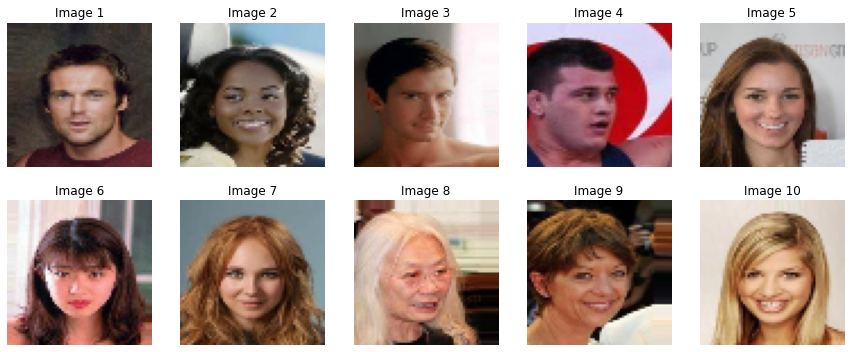

In [19]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(2):
    for j in range(5):
      ax[i, j].imshow(ae_train[i*5 + j])
      ax[i, j].axis('off')
      ax[i, j].set_title(f'Image {i*5 + j + 1}')
plt.show()

Delete to free some ram space

In [20]:
del ae_dataset
del ae_train
del ae_test
del ae_vali
gc.collect()

90

#Encoder Part

In [21]:
latentDim = 64
inputShape = (hight, hight, 3)
chanDim = 3
depth = 1

In [22]:
inputs = Input(shape=inputShape)
x = inputs

x = Conv2D(32, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

x = Conv2D(64, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

x = Conv2D(128, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

volumeSize = K.int_shape(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
latent = Dense(latentDim)(x)

In [23]:
encoder = Model(inputs, latent, name="encoder")
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                           

#Decoder part

In [24]:
latentInputs = Input(shape=(latentDim,))
x = Dense(256, activation='relu')(latentInputs)
x = Dense(512, activation='relu')(x)
x = Dense(np.prod(volumeSize[1:]))(x)
x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

In [25]:
x = Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

x = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

x = Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)
x = LeakyReLU(alpha=0.2)(x)
x = BatchNormalization(axis=chanDim)(x)

In [26]:
x = Conv2DTranspose(3, (3, 3), padding="same")(x)
outputs = Activation("sigmoid")(x)

In [27]:
decoder = Model(latentInputs, outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_3 (Dense)             (None, 256)               16640     
                                                                 
 dense_4 (Dense)             (None, 512)               131584    
                                                                 
 dense_5 (Dense)             (None, 8192)              4202496   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      147584    
 nspose)                                                         
                                                           

In [28]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 encoder (Functional)        (None, 64)                4436736   
                                                                 
 decoder (Functional)        (None, 64, 64, 3)         4592323   
                                                                 
Total params: 9,029,059
Trainable params: 9,028,163
Non-trainable params: 896
_________________________________________________________________


In [29]:
encoder.build(inputShape)
decoder.build(inputShape)
autoencoder.build(inputShape)

In [30]:
autoencoder.compile(loss="mse", optimizer=Adam(learning_rate=1e-2))

#Spliting datasets

In [31]:
train = np.load('/content/ae_train.npy')
validation = np.load('/content/ae_vali.npy')

In [32]:
!mkdir checkpoints
!mkdir logs
!mkdir logs/fit

mkdir: cannot create directory ‘checkpoints’: File exists


In [33]:
checkpoint_path = "/content/drive/MyDrive/AutoEncoders/best_model_64.h5"
log_dir = "/content/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
backup_dir = '/content/drive/MyDrive/AutoEncoders/backup.h5'

In [34]:
backups = BackupAndRestore(backup_dir, save_freq="epoch", delete_checkpoint=True, save_before_preemption=False)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, write_graph=True, update_freq='epoch',
                          profile_batch=0, embeddings_freq=0, embeddings_metadata=None, embeddings_data=None)
callbacks = [checkpoint, lr_reduce]

i load the latest best model

In [35]:
filename = 'best_model.h5'
!cp -r /content/drive/MyDrive/AutoEncoders/best_model_64.h5 /content/
print(f'The file {filename} was copied.')


The file best_model.h5 was copied.


if the file doesn't exist we just train from scratch

In [36]:
if os.path.exists(filename) and (not scratch):
    autoencoder.load_weights('/content/best_model_64.h5')
    print('weights loaded')
else:
  print('not loaded')

not loaded


In [37]:
EPOCHS = 75
Batch_Size = 64

In [38]:
# %tensorboard --logdir logs

In [39]:
if wannaTrain:
	history = autoencoder.fit(
		x= train,
		y= train, 
		epochs=EPOCHS,
		validation_data=(validation, validation),
		batch_size=Batch_Size,
		callbacks=callbacks)

Epoch 1/75
608/608 [==============================] - ETA: 0s - loss: 0.0489
Epoch 1: val_loss improved from inf to 0.04752, saving model to /content/drive/MyDrive/AutoEncoders/best_model_64.h5
608/608 [==============================] - 32s 35ms/step - loss: 0.0489 - val_loss: 0.0475 - lr: 0.0100
Epoch 2/75
606/608 [============================>.] - ETA: 0s - loss: 0.0408
Epoch 2: val_loss improved from 0.04752 to 0.04220, saving model to /content/drive/MyDrive/AutoEncoders/best_model_64.h5
608/608 [==============================] - 19s 32ms/step - loss: 0.0408 - val_loss: 0.0422 - lr: 0.0100
Epoch 3/75
607/608 [============================>.] - ETA: 0s - loss: 0.0378
Epoch 3: val_loss improved from 0.04220 to 0.03747, saving model to /content/drive/MyDrive/AutoEncoders/best_model_64.h5
608/608 [==============================] - 19s 32ms/step - loss: 0.0378 - val_loss: 0.0375 - lr: 0.0100
Epoch 4/75
607/608 [============================>.] - ETA: 0s - loss: 0.0341
Epoch 4: val_loss imp

In [40]:
del train
del validation
gc.collect()

1665

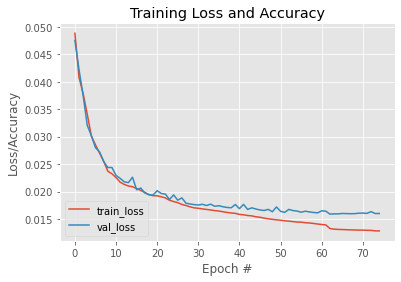

In [41]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [42]:
ae_test = np.load('/content/ae_test.npy')

In [43]:
autoencoder.load_weights('/content/drive/MyDrive/AutoEncoders/best_model_64.h5')

In [44]:
print("[INFO] making predictions...")
decoded = autoencoder.predict(ae_test)
outputs = None

[INFO] making predictions...
380/380 [==============================] - 3s 5ms/step


In [45]:
from sklearn.metrics import mean_squared_error

In [46]:
mse = mean_squared_error(np.reshape(ae_test, (-1, 3)), np.reshape(decoded, (-1, 3)))
print(mse)

0.014074425


In [47]:
decoded.shape

(12156, 64, 64, 3)

In [48]:
decoded.shape[0]//5

2431

In [49]:
ran = sample(range(decoded.shape[0]//5), 5)

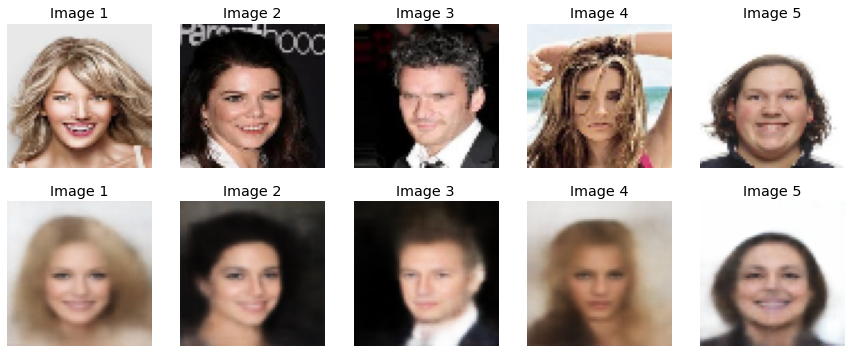

In [59]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(2):
    for j in range(5):
      if i == 0:
        ax[i, j].imshow(ae_test[ran[j] * 5 + j])
        ax[i, j].axis('off')
        ax[i, j].set_title(f'Image {0*5 + j + 1}')
      else:
        ax[i, j].imshow(decoded[ran[j] * 5 + j])
        ax[i, j].axis('off')
        ax[i, j].set_title(f'Image {0*5 + j + 1}')

plt.show()